## 30-Day Readmission Risk Prediction & Care Prioritization (MIMIC-IV Demo 2.2)

## Business Problem

Unplanned hospital readmissions:

Increase healthcare costs

Reduce quality scores

Trigger CMS penalties

## Goal:
Predict patients at high risk of 30-day readmission and rank them for targeted care interventions.

This notebook builds a supervised machine learning model to predict
30-day hospital readmissions using the MIMIC-IV Clinical Database (Demo 2.2).

The goal is to identify high-risk patients for targeted care management,
supporting value-based care and hospital quality improvement initiatives.

In [1]:
import os

# Prevent Windows OpenBLAS / sklearn threading issues

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)

## Load Data-set 

In [2]:
patients = pd.read_csv('patients.csv')
admissions = pd.read_csv('admissions.csv')
diagnoses = pd.read_csv("diagnoses_icd.csv")
icustays = pd.read_csv("icustays.csv")

## Data Understanding (Exploratory Data Analysis)

In [3]:
patients.head(), admissions.head(), diagnoses.head()

(   subject_id gender  anchor_age  anchor_year anchor_year_group         dod
 0    10014729      F          21         2125       2011 - 2013         NaN
 1    10003400      F          72         2134       2011 - 2013  2137-09-02
 2    10002428      F          80         2155       2011 - 2013         NaN
 3    10032725      F          38         2143       2011 - 2013  2143-03-30
 4    10027445      F          48         2142       2011 - 2013  2146-02-09,
    subject_id   hadm_id            admittime            dischtime  \
 0    10004235  24181354  2196-02-24 14:38:00  2196-03-04 14:02:00   
 1    10009628  25926192  2153-09-17 17:08:00  2153-09-25 13:20:00   
 2    10018081  23983182  2134-08-18 02:02:00  2134-08-23 19:35:00   
 3    10006053  22942076  2111-11-13 23:39:00  2111-11-15 17:20:00   
 4    10031404  21606243  2113-08-04 18:46:00  2113-08-06 20:57:00   
 
              deathtime admission_type admit_provider_id  \
 0                  NaN         URGENT            P03YM

In [4]:
admissions[['subject_id', 'hadm_id']].nunique()

subject_id    100
hadm_id       275
dtype: int64

## Create Readmission Label (CORE LOGIC)

In [5]:
admissions = admissions.sort_values(['subject_id', 'admittime'])

admissions['next_admit_time'] = (
    admissions.groupby('subject_id')['admittime'].shift(-1)
)

admissions['readmitted_30d'] = (
    (pd.to_datetime(admissions['next_admit_time']) -
     pd.to_datetime(admissions['dischtime'])
    ).dt.days <= 30
).astype(int)

admissions[['subject_id', 'hadm_id', 'readmitted_30d']].head()

,subject_id,hadm_id,readmitted_30d
18,10000032,22595853,0
103,10000032,22841357,1
105,10000032,29079034,1
104,10000032,25742920,0
65,10001217,24597018,1


## Admission-Level Features

In [6]:
admission_features = admissions.groupby('subject_id').agg(
    num_admissions=('hadm_id', 'nunique'),
    avg_length_of_stay=(
        'dischtime',
        lambda x: np.mean(
            (pd.to_datetime(x) -
             pd.to_datetime(admissions.loc[x.index, 'admittime'])
            ).dt.days
        )
    )
).reset_index()

## Diagnosis Features (Chronic Signal)

In [7]:
diagnosis_features = (
    diagnoses
    .groupby('subject_id')
    .agg(
        num_unique_diagnoses=('icd_code', 'nunique')
    )
    .reset_index()
)

diagnosis_features['chronic_condition_flag'] = (
    diagnosis_features['num_unique_diagnoses'] >= 3
).astype(int)

diagnosis_features.head()

,subject_id,num_unique_diagnoses,chronic_condition_flag
0,10000032,21,1
1,10001217,12,1
2,10001725,18,1
3,10002428,84,1
4,10002495,26,1


In [8]:
assert 'subject_id' in diagnosis_features.columns
diagnosis_features.shape
diagnosis_features.isna().sum()

subject_id                0
num_unique_diagnoses      0
chronic_condition_flag    0
dtype: int64

## ICU Severity Features

In [9]:
icu_features = icustays.groupby('subject_id').agg(
    icu_visits_count=('stay_id', 'nunique'),
    total_icu_days=(
        'outtime',
        lambda x: np.sum(
            (pd.to_datetime(x) -
             pd.to_datetime(icustays.loc[x.index, 'intime'])
            ).dt.days
        )
    )
).reset_index()

## Demographics

In [10]:
patients['age'] = 2020 - patients['anchor_year']

patients['age_bucket'] = pd.cut(
    patients['age'],
    bins=[0, 30, 50, 120],
    labels=['Under 30', '30-50', '50+']
)

patient_features = patients[['subject_id', 'gender', 'age_bucket']]

## Merge Feature Table

In [11]:
model_df = (
    patient_features
    .merge(admission_features, on='subject_id', how='left')
    .merge(diagnosis_features, on='subject_id', how='left')
    .merge(icu_features, on='subject_id', how='left')
)

model_df.head()

,subject_id,gender,age_bucket,num_admissions,avg_length_of_stay,num_unique_diagnoses,chronic_condition_flag,icu_visits_count,total_icu_days
0,10014729,F,NaN,2,7.500000,18,1,1,2
1,10003400,F,NaN,7,11.142857,113,1,3,30
2,10002428,F,NaN,7,5.000000,84,1,4,23
3,10032725,F,NaN,2,15.000000,31,1,1,3
4,10027445,F,NaN,3,9.000000,41,1,2,4


## Add Target Variable

In [12]:
readmission_label = admissions.groupby('subject_id').agg(
    readmitted_30d=('readmitted_30d', 'max')
).reset_index()

model_df = model_df.merge(
    readmission_label,
    on='subject_id',
    how='left'
)

## Missing Value Handling

In [13]:
# Numeric columns
num_cols = model_df.select_dtypes(include=['int64', 'float64']).columns
model_df[num_cols] = model_df[num_cols].fillna(0)

# Object columns (safe)
obj_cols = model_df.select_dtypes(include=['object']).columns
model_df[obj_cols] = model_df[obj_cols].fillna('Unknown')

# Categorical columns (special handling)
cat_cols = model_df.select_dtypes(include=['category']).columns

for col in cat_cols:
    model_df[col] = (
        model_df[col]
        .cat.add_categories('Unknown')
        .fillna('Unknown')
    )

In [14]:
model_df.isna().sum().sum()
model_df.dtypes.value_counts()

int64       5
int32       2
object      1
category    1
float64     1
Name: count, dtype: int64

## Encode & Scale

In [15]:
model_df_encoded = pd.get_dummies(
    model_df,
    columns=['gender', 'age_bucket'],
    drop_first=True
)

X = model_df_encoded.drop(
    columns=['subject_id', 'readmitted_30d']
)
y = model_df_encoded['readmitted_30d']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## Logistic Regression Model

In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

## Model Evaluation

ROC AUC: 0.8409090909090908
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        22
           1       1.00      0.12      0.22         8

    accuracy                           0.77        30
   macro avg       0.88      0.56      0.54        30
weighted avg       0.82      0.77      0.69        30



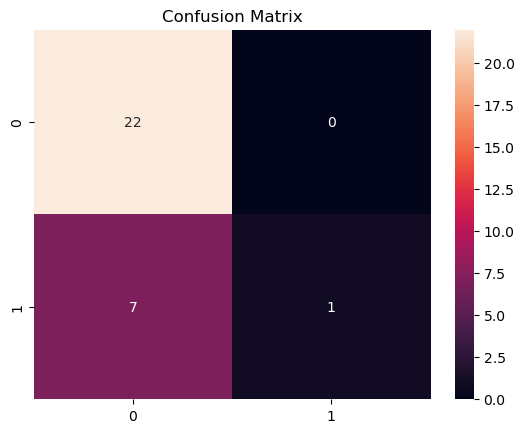

In [18]:
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='d'
)

plt.title("Confusion Matrix")
plt.show()

## Risk Scoring & Care Prioritization

In [19]:
model_df['readmission_risk_score'] = model.predict_proba(X_scaled)[:, 1]

model_df['risk_tier'] = pd.cut(
    model_df['readmission_risk_score'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low', 'Medium', 'High']
)

model_df[['subject_id', 'risk_tier']].value_counts()

subject_id  risk_tier
10000032    Medium       1
10021487    Medium       1
10024043    Low          1
10023771    Low          1
10023239    Medium       1
                        ..
10011398    Low          1
10010867    Medium       1
10010471    Low          1
10009628    Low          1
10040025    High         1
Name: count, Length: 100, dtype: int64

## Business Interpretation

- High-risk patients show higher admission frequency and ICU utilization
- Chronic condition signals strongly influence readmission probability
- This model supports proactive care management and transitional care planning